In [46]:
from cslib import fetch_data, convert_to_ts, engineer_features
import time
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston

# Model building and selection

Tasks:
* State the different modeling approaches that you will compare to address the business opportunity.
* Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
* Re-train your model on all of the data using the selected approach and prepare it for deployment.
* Articulate your findings in a summary report.

**Model should predict the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number.**

In [3]:
# Setup the initial variables
run_start = time.time() 
data_dir = os.path.join("..","cs-train")
print("...fetching data")

# Fetching data may take a few seconds
df = fetch_data(data_dir)

# Calculate time taken and display
m, s = divmod(time.time()-run_start,60)
h, m = divmod(m, 60)
print("load time:", "%d:%02d:%02d"%(h, m, s))

# Print the data
df.head()

...fetching data
load time: 0:00:08


,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


## Models to investigate

I will investigate the ability of a random forest algorithm to predict revenue.

## Feature Extraction

Initially we need to obtain the data in a form that we can use in a model.

In [54]:
# Look at which features have most missing values
df.isna().sum()

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64

In [40]:
# Convert the dataframe to a timeseries
ts = convert_to_ts(df)
ts.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [41]:
# Create new features for training
(X, y, dates) = engineer_features(ts)

In [42]:
# The feature data
X.head()

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views
0,14450.54,14450.54,14450.54,14450.54,0.0,5.928571,537.392857
1,27862.50,27862.50,27862.50,27862.50,0.0,10.310345,1007.103448
2,41152.75,41152.75,41152.75,41152.75,0.0,14.966667,1499.066667
3,50840.03,50840.03,50840.03,50840.03,0.0,18.533333,1916.533333
4,52283.29,52283.29,52283.29,52283.29,0.0,19.600000,2026.966667


In [43]:
# The response data
y[0:5]

array([183857.22, 170445.26, 157155.01, 147467.73, 147991.02])

In [44]:
# The dates
dates[0:5]

array(['2017-11-29', '2017-11-30', '2017-12-01', '2017-12-02',
       '2017-12-03'], dtype='datetime64[D]')

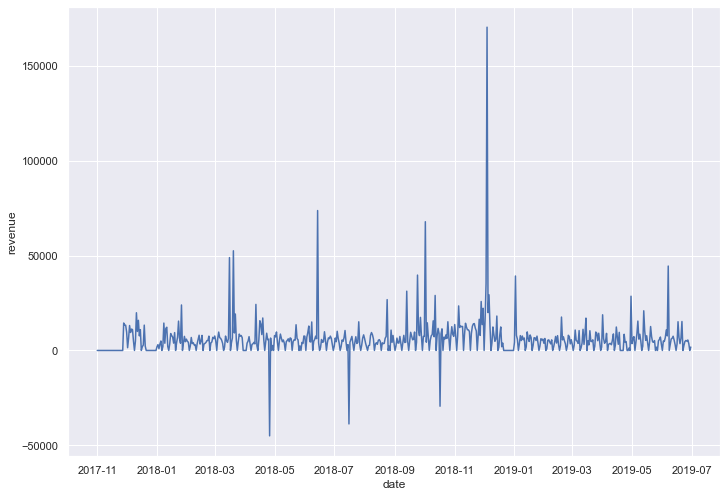

In [55]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.lineplot(data=ts, x='date', y='revenue')

## Random Forest

Having extracted the features we can now construct a pipeline for this data.

In [47]:
# Create a train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [49]:
# Create a random forest pipeline
pipe = Pipeline([("scaler", StandardScaler()),
                 ("rf", RandomForestRegressor(n_estimators=20))])

## train on the training data
pipe.fit(X_train, y_train)

## evaluate the model with the test data
y_pred = pipe.predict(X_test)
print(r'R^2=%.2f, MAE=%.2f'%(r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))

R^2=0.94, MAE=8328.06


Just by applying a simple random forest regressor we seem to already be getting an R^2 value of 0.94 which is promising and leads us to want to see if we can do even better.